<a href="https://colab.research.google.com/github/DimaKav/python-marketing-projects/blob/master/Data_Science_for_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes from the book "Hands-On Data Science for Marketing" by Yoon Hyup Hwang

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
import graphviz

# 1. Descriptive Analysis - Visualizing KPIs

Dataset description: https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/DimaKav/python-marketing-projects/master/bank-full.csv', sep=';')

In [3]:
df.shape

(45211, 17)

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


y - has the client subscribed a term deposit? (binary: 'yes','no')

In [0]:
# Encode the y
labels, uniques = pd.factorize(df['y'])
df['conversion'] = labels

In [6]:
# Aggregate conversion rate: overall performance of our marketing campaign

print('total conversions: %i out of %i' % (df.conversion.sum(), df.shape[0]))
print('conversion rate: %0.2f%%' % (df.conversion.sum() / df.shape[0] * 100.0))

total conversions: 5289 out of 45211
conversion rate: 11.70%


Let's dive deeper and break the customer base into multiple segments by age and compute KPIs for individual segments.

In [0]:
conversions_by_age = df.groupby(
    by='age'
)['conversion'].sum() / df.groupby(
    by='age'
)['conversion'].count() * 100.0

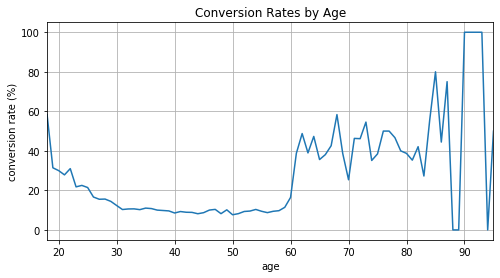

In [8]:
ax = conversions_by_age.plot(
    grid=True,
    figsize=(8, 4),
    title='Conversion Rates by Age'
)

ax.set_xlabel('age')
ax.set_ylabel('conversion rate (%)')

plt.show()

There aren't many clients who are 80 or older so that data is noisy on the chart. To reduce the noise, we can group multiple ages together.

In [0]:
df['age_group'] = df['age'].apply(
    lambda x: '[18, 30)' if x < 30 else '[30, 40)' if x < 40 \
        else '[40, 50)' if x < 50 else '[50, 60)' if x < 60 \
        else '[60, 70)' if x < 70 else '70+'
)

In [0]:
conversions_by_age_group = df.groupby(
    by='age_group'
)['conversion'].sum() / df.groupby(
    by='age_group'
)['conversion'].count() * 100.0

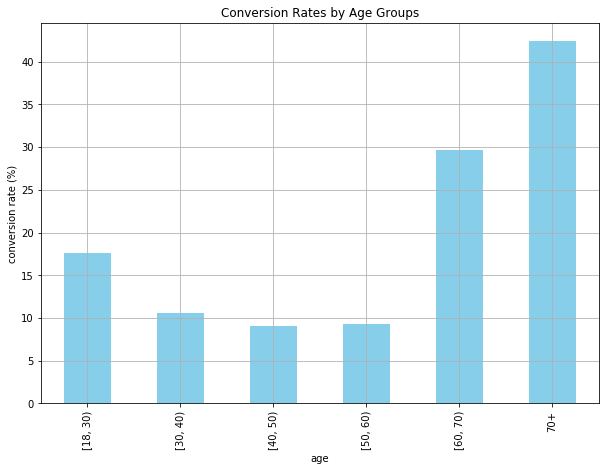

In [11]:
ax = conversions_by_age_group.loc[
    ['[18, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '70+']
].plot(
    kind='bar',
    color='skyblue',
    grid=True,
    figsize=(10, 7),
    title='Conversion Rates by Age Groups'
)

ax.set_xlabel('age')
ax.set_ylabel('conversion rate (%)')

plt.show()

Let's look at the demographic differences between the converted clients and the non-converted clients.

In [0]:
conversions_by_marital_status_df = pd.pivot_table(df, values='y', 
                                               index='marital', 
                                               columns='conversion', 
                                               aggfunc=len)

In [0]:
conversions_by_marital_status_df.rename(columns={0: 'non-conversion'}, inplace=True)
conversions_by_marital_status_df.rename(columns={1: 'conversion'}, inplace=True)

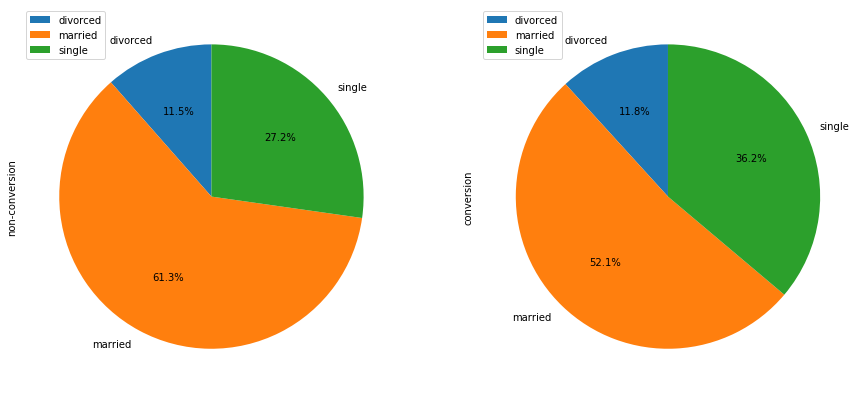

In [14]:
conversions_by_marital_status_df.plot(
    kind='pie',
    figsize=(15, 7),
    startangle=90,
    subplots=True,
    autopct=lambda x: '%0.1f%%' % x
)

plt.show()

Let's look at conversions by age and marital status.

In [0]:
age_marital_df = df.groupby(['age_group', 'marital'])['conversion'].sum().unstack('marital').fillna(0)

age_marital_df = age_marital_df.divide(
    df.groupby(
        by='age_group'
    )['conversion'].count(),
    axis=0
)

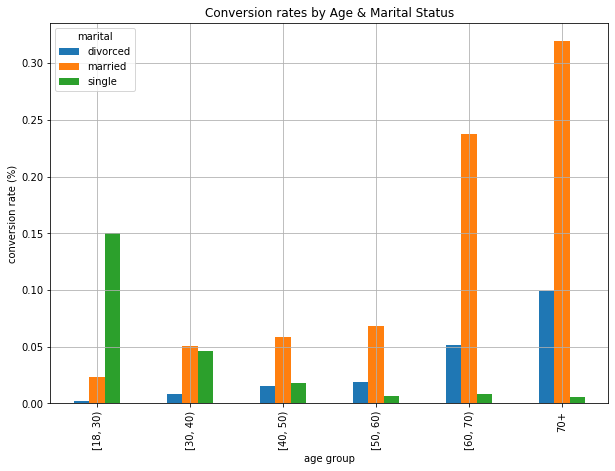

In [16]:
ax = age_marital_df.loc[
    ['[18, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '70+']
].plot(
    kind='bar', 
    grid=True,
    figsize=(10,7)
)

ax.set_title('Conversion rates by Age & Marital Status')
ax.set_xlabel('age group')
ax.set_ylabel('conversion rate (%)')

plt.show()

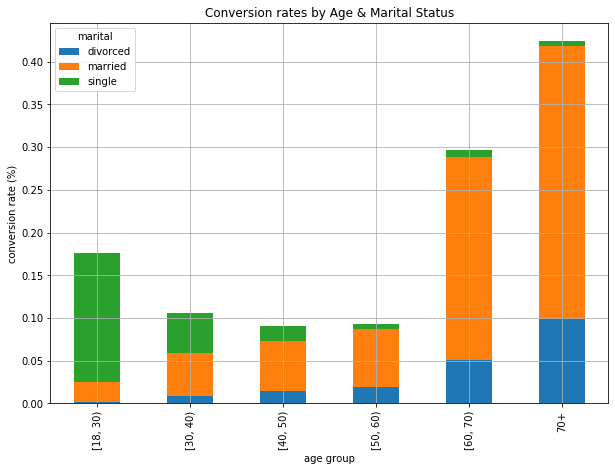

In [17]:
ax = age_marital_df.loc[
    ['[18, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '70+']
].plot(
    kind='bar', 
    stacked=True,
    grid=True,
    figsize=(10,7)
)

ax.set_title('Conversion rates by Age & Marital Status')
ax.set_xlabel('age group')
ax.set_ylabel('conversion rate (%)')

plt.show()

# 2. Customer Engagement 

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/DimaKav/python-marketing-projects/master/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

In [19]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [20]:
df.shape

(9134, 24)

In [0]:
# Encode the response column
labels, uniques = pd.factorize(df['Response'])
df['Engaged'] = labels

In [0]:
# Agg engagement rate
engagement_rate_df = pd.DataFrame(
    df.groupby('Engaged').count()['Response'] / df.shape[0] * 100.0
)

In [23]:
engagement_rate_df.T

Engaged,0,1
Response,85.679877,14.320123


~85% of the customers have not responded to marketing calls. Let's look at engagement per sales channel.

In [0]:
engagement_by_sales_channel_df = pd.pivot_table(
    df, values='Response', index='Sales Channel', columns='Engaged', aggfunc=len
).fillna(0.0)

engagement_by_sales_channel_df.columns = ['Not Engaged', 'Engaged']

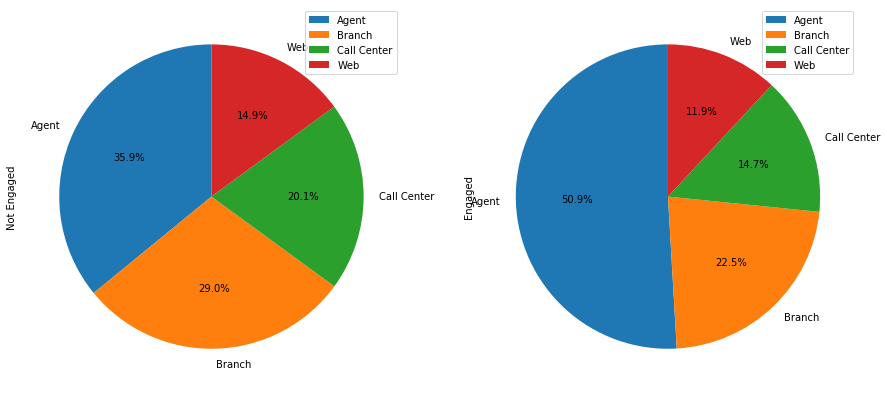

In [25]:
engagement_by_sales_channel_df.plot(
    kind='pie',
    figsize=(15, 7),
    startangle=90,
    subplots=True,
    autopct=lambda x: '%0.1f%%' % x
)

plt.show()

Now let's looks at total claim amount.

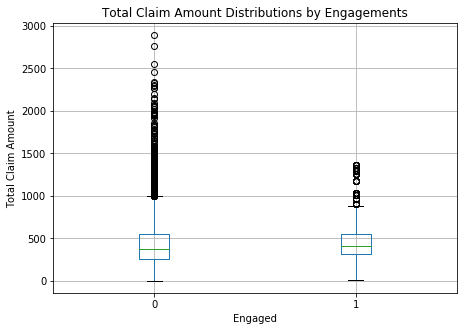

In [26]:
ax = df[['Engaged', 'Total Claim Amount']].boxplot(
    by='Engaged',
    showfliers=True,
    figsize=(7,5)
)

ax.set_xlabel('Engaged')
ax.set_ylabel('Total Claim Amount')
ax.set_title('Total Claim Amount Distributions by Engagements')

plt.suptitle("")
plt.show()

# 3. Explanatory Analysis - Logistic Regression of Engagement

In [0]:
continuous_vars = [
    'Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 
    'Months Since Last Claim', 'Months Since Policy Inception', 
    'Number of Open Complaints', 'Number of Policies', 
    'Total Claim Amount' 
]

logit = sm.Logit(
    df['Engaged'],
    df[continuous_vars]
)

In [28]:
logit_fit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.421189
         Iterations 6


In [29]:
logit_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Engaged   No. Observations:                 9134
Model:                          Logit   Df Residuals:                     9126
Method:                           MLE   Df Model:                            7
Date:                Sun, 27 Oct 2019   Pseudo R-squ.:                -0.02546
Time:                        12:21:42   Log-Likelihood:                -3847.1
converged:                       True   LL-Null:                       -3751.6
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Customer Lifetime Value       -6.741e-06   5.04e-06     -1.337      0.181   -1.66e-05    3.14e-06
Income                        -2.857e-06   1.03e-06     -2.766      0.006   -4.88e-06   -8.33e-07
Monthly Premium Auto             -0.0084      0.001     -6.889      0.000      -0.011      -0.006
Months Since Last Claim          -0.0202      0.003     -7.238      0.000      -0.026      -0.015
Months Since Policy Inception    -0.0060      0.001     -6.148      0.000      -0.008      -0.004
Number of Open Complaints        -0.0829      0.034     -2.424      0.015      -0.150      -0.016
Number of Policies               -0.0810      0.013     -6.356      0.000      -0.106      -0.056
Total Claim Amount                0.0001      0.000      0.711      0.477      -0.000       0.000
=================================================================================================
"""

In [30]:
# Factorize the rest of the variables and run the regression again

gender_values, gender_labels = df['Gender'].factorize()

categories = pd.Categorical(
    df['Education'], 
    categories=['High School or Below', 'Bachelor', 'College', 'Master', 'Doctor']
)

df['GenderFactorized'] = gender_values
df['EducationFactorized'] = categories.codes

logit = sm.Logit(
    df['Engaged'], 
    df[[
        'GenderFactorized',
        'EducationFactorized'
    ]]
)

logit_fit = logit.fit()

logit_fit.summary()

Optimization terminated successfully.
         Current function value: 0.493068
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Engaged   No. Observations:                 9134
Model:                          Logit   Df Residuals:                     9132
Method:                           MLE   Df Model:                            1
Date:                Sun, 27 Oct 2019   Pseudo R-squ.:                 -0.2005
Time:                        12:21:42   Log-Likelihood:                -4503.7
converged:                       True   LL-Null:                       -3751.6
Covariance Type:            nonrobust   LLR p-value:                     1.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
GenderFactorized       -1.1266      0.047    -24.116      0.000      -1.218      -1.035
EducationFactorized    -0.6256      0.021    -29.900      0.000      -0.667      -0.585
=======================================================================================
"""

In [31]:
# Combine continuous and categorical
logit = sm.Logit(
    df['Engaged'], 
    df[['Customer Lifetime Value',
        'Income',
        'Monthly Premium Auto',
        'Months Since Last Claim',
        'Months Since Policy Inception',
        'Number of Open Complaints',
        'Number of Policies',
        'Total Claim Amount',
        'GenderFactorized',
        'EducationFactorized'
    ]]
)

logit_fit = logit.fit()

logit_fit.summary()

Optimization terminated successfully.
         Current function value: 0.420810
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Engaged   No. Observations:                 9134
Model:                          Logit   Df Residuals:                     9124
Method:                           MLE   Df Model:                            9
Date:                Sun, 27 Oct 2019   Pseudo R-squ.:                -0.02454
Time:                        12:21:42   Log-Likelihood:                -3843.7
converged:                       True   LL-Null:                       -3751.6
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Customer Lifetime Value       -6.909e-06   5.03e-06     -1.373      0.170   -1.68e-05    2.96e-06
Income                         -2.59e-06   1.04e-06     -2.494      0.013   -4.63e-06   -5.55e-07
Monthly Premium Auto             -0.0081      0.001     -6.526      0.000      -0.011      -0.006
Months Since Last Claim          -0.0194      0.003     -6.858      0.000      -0.025      -0.014
Months Since Policy Inception    -0.0057      0.001     -5.827      0.000      -0.008      -0.004
Number of Open Complaints        -0.0813      0.034     -2.376      0.017      -0.148      -0.014
Number of Policies               -0.0781      0.013     -6.114      0.000      -0.103      -0.053
Total Claim Amount                0.0001      0.000      0.943      0.346      -0.000       0.000
GenderFactorized                 -0.1500      0.058     -2.592      0.010      -0.263      -0.037
EducationFactorized              -0.0070      0.027     -0.264      0.792      -0.059       0.045
=================================================================================================
"""

The most prominent relationship is income and engagement with marketing calls, they are inverserly related. People with higher income are less likely to engage with marketing calls. More generally, the negative coefficients are interpreted as the higher the ____ the less likely the person will be engaged. The inverse is true for positive coefficients.

# 4. Explanatory Analysis - Decision Trees

The main difference between logistic regression and decision tree models is the fact that logistic regression algorithms search for a single best linear boundary in the feature set, whereas the decision tree algorithm partitions the data to find the subgroups of data that have high likelihoods of an event occurring. When there is no linear structure in the data, logistic regression models will not be able to perform well, as they try to find linear combinations among the feature variables. On the other hand, decision tree models will perform better for non-linear datasets, as they only try to partition the data at the purest levels they can.

In [0]:
# Load dataset from section 1
df = pd.read_csv('https://raw.githubusercontent.com/DimaKav/python-marketing-projects/master/bank-full.csv', sep=';')

In [33]:
df.shape

(45211, 17)

In [34]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [0]:
# Encode the y
labels, uniques = pd.factorize(df['y'])
df['conversion'] = labels

In [0]:
conversion_rate_df = pd.DataFrame(
    df.groupby('conversion').count()['y'] / df.shape[0] * 100.0
)

In [37]:
conversion_rate_df

,y
conversion,
0,88.30152
1,11.69848


11.7% converted and subscribed to a term deposit...

In [0]:
conversion_rate_by_job = df.groupby(
    by='job'
)['conversion'].sum() / df.groupby(
    by='job'
)['conversion'].count() * 100.0

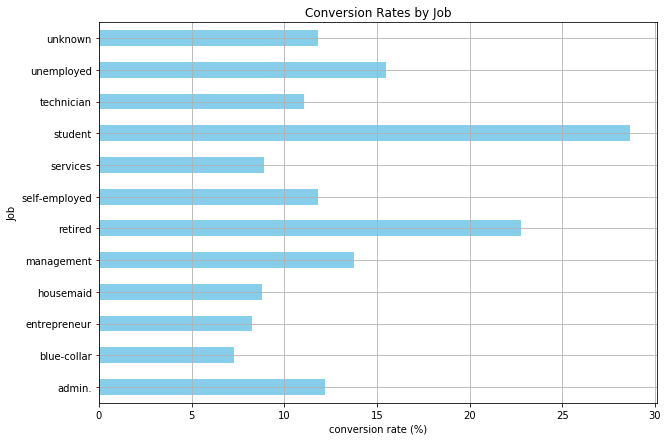

In [39]:
ax = conversion_rate_by_job.plot(
    kind='barh',
    color='skyblue',
    grid=True,
    figsize=(10, 7),
    title='Conversion Rates by Job'
)

ax.set_xlabel('conversion rate (%)')
ax.set_ylabel('Job')

plt.show()

Let's see how the default rate differs between those who subscribed and those who did not.

In [40]:
default_by_conversion_df = pd.pivot_table(
    df, 
    values='y', 
    index='default', 
    columns='conversion', 
    aggfunc=len
)

default_by_conversion_df.columns = ['did not convert', 'converted']

default_by_conversion_df

,did not convert,converted
default,,
no,39159,5237
yes,763,52


In [41]:
default_by_conversion_df/ default_by_conversion_df.sum() * 100

,did not convert,converted
default,,
no,98.088773,99.016827
yes,1.911227,0.983173


The customers in default are ~twice as likely to not convert. Let's see the distribution of bank balances by conversion and nonconversion groups.

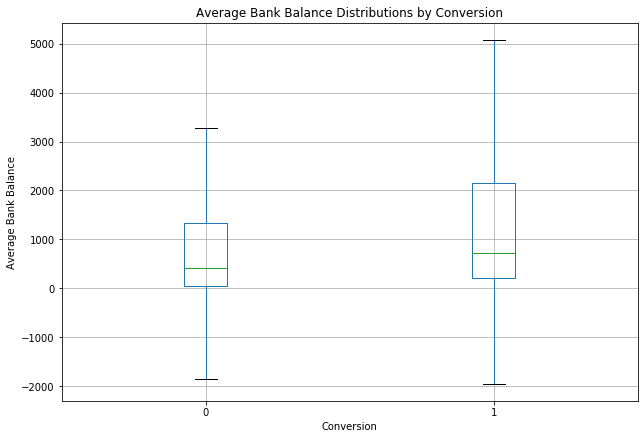

In [42]:
# There are a ton of outliers, so showfliers=False to set to IQR
ax = df[['conversion', 'balance']].boxplot(
    by='conversion',
    showfliers=False,
    figsize=(10, 7)
)

ax.set_xlabel('Conversion')
ax.set_ylabel('Average Bank Balance')
ax.set_title('Average Bank Balance Distributions by Conversion')

plt.suptitle("")
plt.show()

Bank balances of converted customers varies more to the upside and their median is higher.

Typically, in marketing, a higher number of marketing touches can result in marketing fatigue, where the conversion rates drop as you reach out to your customers more frequently. Let's see whether there is any marketing fatigue in our data.

In [0]:
conversions_by_num_contacts = df.groupby(
    by='campaign'
)['conversion'].sum() / df.groupby(
    by='campaign'
)['conversion'].count() * 100.0

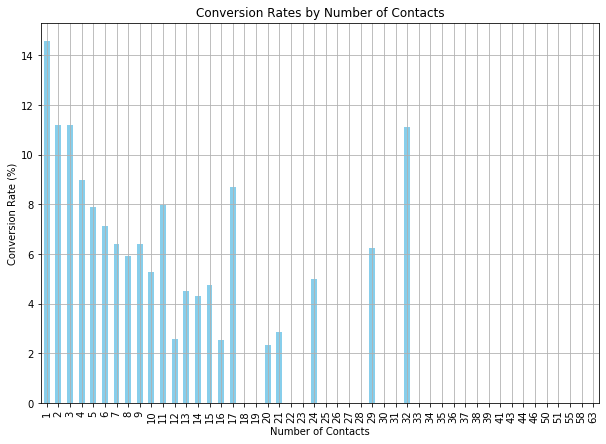

In [44]:
ax = conversions_by_num_contacts.plot(
    kind='bar',
    figsize=(10, 7),
    title='Conversion Rates by Number of Contacts',
    grid=True,
    color='skyblue'
)

ax.set_xlabel('Number of Contacts')
ax.set_ylabel('Conversion Rate (%)')

plt.show()

The conversion rate decreases as you contact a client more frequently for a given campaign.

In [0]:
# Encode the non numeric columns

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df['month'] = df['month'].apply(
    lambda x: months.index(x)+1
)

jobs_encoded_df = pd.get_dummies(df['job'])
jobs_encoded_df.columns = ['job_%s' % x for x in jobs_encoded_df.columns]

df = pd.concat([df, jobs_encoded_df], axis=1)

marital_encoded_df = pd.get_dummies(df['marital'])
marital_encoded_df.columns = ['marital_%s' % x for x in marital_encoded_df.columns]

df = pd.concat([df, marital_encoded_df], axis=1)

df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)

df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [46]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'conversion', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single'],
      dtype='object')

In [47]:
# Build the model

features = ['age','balance','campaign','previous','housing','job_admin.',
           'job_blue-collar','job_entrepreneur','job_housemaid','job_management',
           'job_self-employed','job_services','job_student','job_technician',
           'job_unemployed','job_unknown','marital_divorced','marital_married',
           'marital_single']

dt_model = DecisionTreeClassifier(max_depth=4)
dt_model.fit(df[features], df['y'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
from sklearn import tree
dot_data = tree.export_graphviz(
    dt_model, 
    feature_names=features, 
    class_names=['0', '1'], 
    filled=True, 
    rounded=True, 
    special_characters=True
) 

graph = graphviz.Source(dot_data)

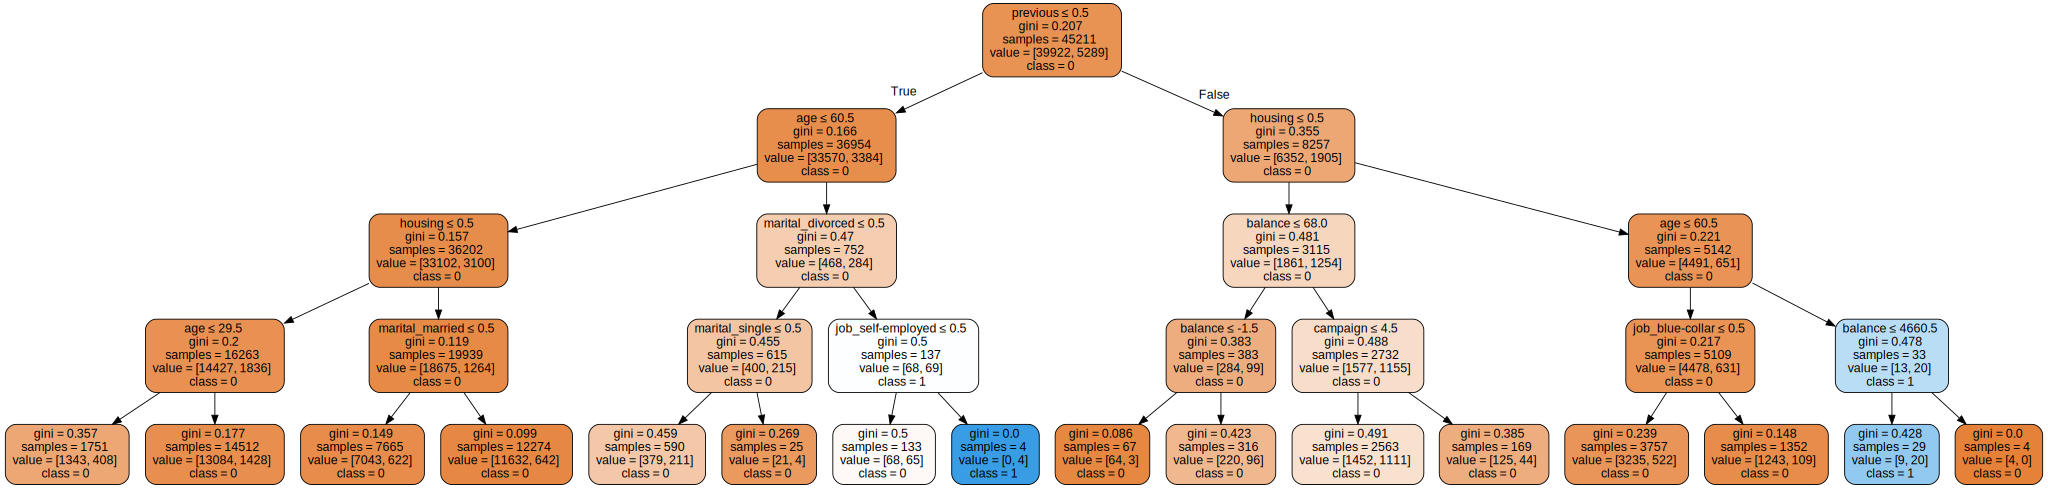

In [49]:
graph

# 5. Exploratory Analysis - Product Analytics

Why product analytics are important:

* Improve customer and product retention.
* Identify popular and trending products.
* Segment customers and products based on their key attributes.
* Develop marketing strategies with higher ROI.

Dataset description: http://archive.ics.uci.edu/ml/datasets/online+retail#

In [0]:
# Load data from my dropbox
df = pd.read_csv('https://www.dropbox.com/s/8mnw3ryg4l4mg19/Online_Retail.csv?dl=1', encoding = "ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [51]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [52]:
df.shape

(541909, 8)

In [53]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


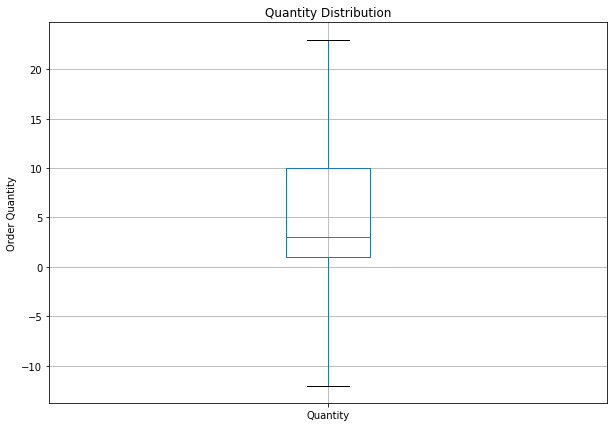

In [54]:
ax = df['Quantity'].plot.box(
    showfliers=False,
    grid=True,
    figsize=(10, 7)
)

ax.set_ylabel('Order Quantity')
ax.set_title('Quantity Distribution')

plt.suptitle("")
plt.show()

Negative order quantity is cancelled or refunded orders, let's filter out all of those.

In [55]:
df = df.loc[df['Quantity'] > 0]
df.shape

(531285, 8)

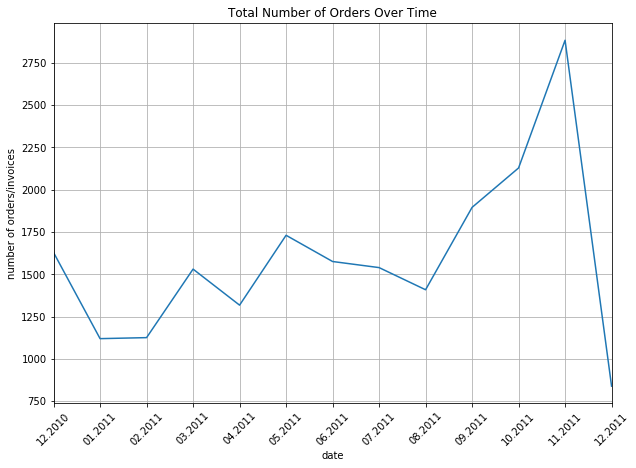

In [56]:
# The number of orders received over time
monthly_orders_df = df.set_index('InvoiceDate')['InvoiceNo'].resample('M').nunique()

ax = pd.DataFrame(monthly_orders_df.values).plot(
    grid=True,
    figsize=(10,7),
    legend=False
)

ax.set_xlabel('date')
ax.set_ylabel('number of orders/invoices')
ax.set_title('Total Number of Orders Over Time')

plt.xticks(
    range(len(monthly_orders_df.index)), 
    [x.strftime('%m.%Y') for x in monthly_orders_df.index], 
    rotation=45
)

plt.show()

Looks like there are errors in the data in December, let's check that out.

In [57]:
invoice_dates = df.loc[
    df['InvoiceDate'] >= '2011-12-01',
    'InvoiceDate'
]

print('Min date: %s\nMax date: %s' % (invoice_dates.min(), invoice_dates.max()))

Min date: 2011-12-01 08:33:00
Max date: 2011-12-09 12:50:00


In [0]:
# Get rid of December
df = df.loc[df['InvoiceDate'] < '2011-12-01']

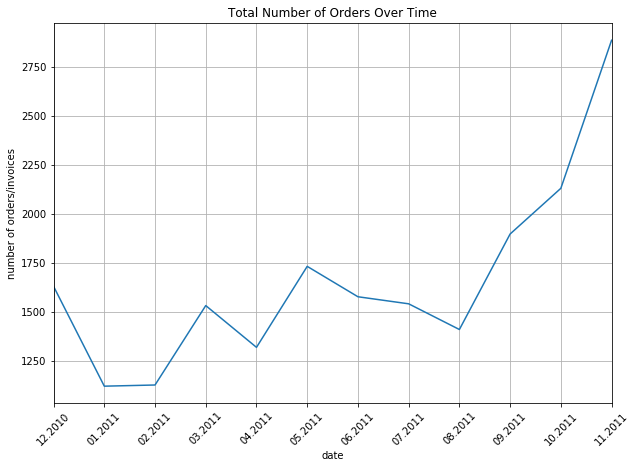

In [59]:
# The number of orders received over time
monthly_orders_df = df.set_index('InvoiceDate')['InvoiceNo'].resample('M').nunique()

ax = pd.DataFrame(monthly_orders_df.values).plot(
    grid=True,
    figsize=(10,7),
    legend=False
)

ax.set_xlabel('date')
ax.set_ylabel('number of orders/invoices')
ax.set_title('Total Number of Orders Over Time')

plt.xticks(
    range(len(monthly_orders_df.index)), 
    [x.strftime('%m.%Y') for x in monthly_orders_df.index], 
    rotation=45
)

plt.show()

Either the business is actually growing or these effects are seasonal. Let's look at the revenue.

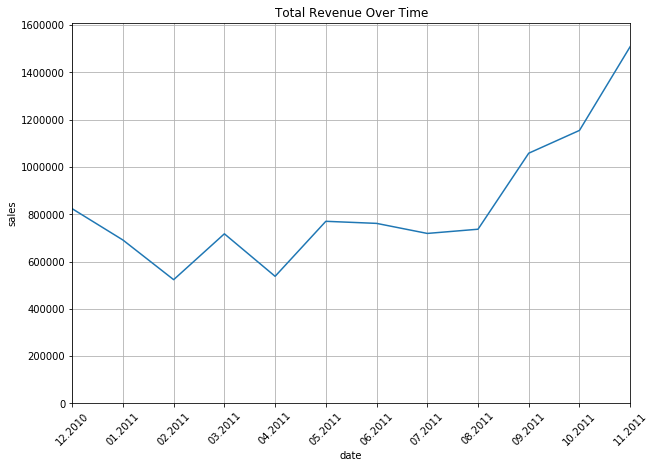

In [60]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

monthly_revenue_df = df.set_index('InvoiceDate')['Sales'].resample('M').sum()

ax = pd.DataFrame(monthly_revenue_df.values).plot(
    grid=True,
    figsize=(10,7),
    legend=False
)

ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.set_title('Total Revenue Over Time')

ax.set_ylim([0, max(monthly_revenue_df.values)+100000])

plt.xticks(
    range(len(monthly_revenue_df.index)), 
    [x.strftime('%m.%Y') for x in monthly_revenue_df.index], 
    rotation=45
)

plt.show()

### Q: How much of the sales are from repeat customers?

In [61]:
df.CustomerID.value_counts()

17841.0    7376
14911.0    5358
14096.0    4582
12748.0    4290
14606.0    2599
           ... 
13307.0       1
13302.0       1
17331.0       1
17986.0       1
13270.0       1
Name: CustomerID, Length: 4298, dtype: int64

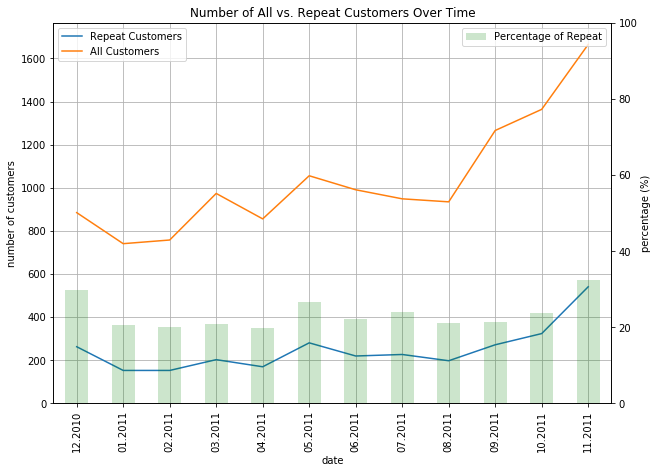

In [62]:
invoice_customer_df = df.groupby(
    by=['InvoiceNo', 'InvoiceDate']
).agg({
    'Sales': sum,
    'CustomerID': max,
    'Country': max,
}).reset_index()

monthly_repeat_customers_df = invoice_customer_df.set_index('InvoiceDate').groupby([
    pd.Grouper(freq='M'), 'CustomerID'
]).filter(lambda x: len(x) > 1).resample('M').nunique()['CustomerID']

monthly_unique_customers_df = df.set_index('InvoiceDate')['CustomerID'].resample('M').nunique()

monthly_repeat_percentage = monthly_repeat_customers_df/monthly_unique_customers_df*100.0

ax = pd.DataFrame(monthly_repeat_customers_df.values).plot(
    figsize=(10,7)
)

pd.DataFrame(monthly_unique_customers_df.values).plot(
    ax=ax,
    grid=True
)

ax2 = pd.DataFrame(monthly_repeat_percentage.values).plot.bar(
    ax=ax,
    grid=True,
    secondary_y=True,
    color='green',
    alpha=0.2
)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('Number of All vs. Repeat Customers Over Time')

ax2.set_ylabel('percentage (%)')

ax.legend(['Repeat Customers', 'All Customers'])
ax2.legend(['Percentage of Repeat'], loc='upper right')

ax.set_ylim([0, monthly_unique_customers_df.values.max()+100])
ax2.set_ylim([0, 100])

plt.xticks(
    range(len(monthly_repeat_customers_df.index)), 
    [x.strftime('%m.%Y') for x in monthly_repeat_customers_df.index], 
    rotation=45
)

plt.show()

# 6. Product Recommendations

Personalized product recommendations improve conversion rates and customer retention rates...

In [0]:
# Load data from my dropbox (data from section 5)
df = pd.read_csv('https://www.dropbox.com/s/8mnw3ryg4l4mg19/Online_Retail.csv?dl=1', encoding = "ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.loc[df['Quantity'] > 0]

In [64]:
df.shape

(531285, 8)

In [65]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133361
Country             0
dtype: int64

In [0]:
# Drop the nans

df = df.dropna(subset=['CustomerID'])

In [0]:
customer_item_matrix = df.pivot_table(
    index='CustomerID', 
    columns='StockCode', 
    values='Quantity',
    aggfunc='sum'
)

### User Collaborative Filtering

In [0]:
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x > 0 else 0)

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
user_user_sim_matrix = pd.DataFrame(
    cosine_similarity(customer_item_matrix)
)

In [0]:
user_user_sim_matrix.columns = customer_item_matrix.index

user_user_sim_matrix['CustomerID'] = customer_item_matrix.index
user_user_sim_matrix = user_user_sim_matrix.set_index('CustomerID')

In [72]:
items_bought_by_A = set(customer_item_matrix.loc[12350.0].iloc[
    customer_item_matrix.loc[12350.0].nonzero()
].index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


In [73]:
items_bought_by_B = set(customer_item_matrix.loc[17935.0].iloc[
    customer_item_matrix.loc[17935.0].nonzero()
].index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


In [0]:
items_to_recommend_to_B = items_bought_by_A - items_bought_by_B

In [75]:
df.loc[
    df['StockCode'].isin(items_to_recommend_to_B), 
    ['StockCode', 'Description']
].drop_duplicates().set_index('StockCode')

,Description
StockCode,
21832,CHOCOLATE CALCULATOR
21915,RED HARMONICA IN BOX
22620,4 TRADITIONAL SPINNING TOPS
79066K,RETRO MOD TRAY
21864,UNION JACK FLAG PASSPORT COVER
79191C,RETRO PLASTIC ELEPHANT TRAY
21908,CHOCOLATE THIS WAY METAL SIGN
20615,BLUE POLKADOT PASSPORT COVER
20652,BLUE POLKADOT LUGGAGE TAG


### Item Based Collaborative Filtering

First, for the given product that the target customer bought, we are going to find the most similar items from the item-to-item similarity matrix that we have just built. Then, we are going to recommend these similar items to the customer, since those similar items were bought by other customers who have bought the product that the target customer initially bought.

In [0]:
item_item_sim_matrix = pd.DataFrame(
    cosine_similarity(customer_item_matrix.T)
)

In [0]:
item_item_sim_matrix.columns = customer_item_matrix.T.index

item_item_sim_matrix['StockCode'] = customer_item_matrix.T.index
item_item_sim_matrix = item_item_sim_matrix.set_index('StockCode')

Assume a new customer just bought a product with stock code 23166 and we want to include some products this customer is most likely to purchase in our marketing emails. Let's find the most similar items.

In [0]:
top_10_similar_items = list(
   item_item_sim_matrix\
        .loc['23166']\
        .sort_values(ascending=False)\
        .iloc[:10]\
    .index
)

In [100]:
top_10_similar_items

['23166',
 '23165',
 '23167',
 '22993',
 '23307',
 '22722',
 '22720',
 '22666',
 '23243',
 '22961']

In [101]:
# Get descriptions of these items
df.loc[
    df['StockCode'].isin(top_10_similar_items), 
    ['StockCode', 'Description']
].drop_duplicates().set_index('StockCode').loc[top_10_similar_items]

,Description
StockCode,
23166,MEDIUM CERAMIC TOP STORAGE JAR
23165,LARGE CERAMIC TOP STORAGE JAR
23167,SMALL CERAMIC TOP STORAGE JAR
22993,SET OF 4 PANTRY JELLY MOULDS
23307,SET OF 60 PANTRY DESIGN CAKE CASES
22722,SET OF 6 SPICE TINS PANTRY DESIGN
22720,SET OF 3 CAKE TINS PANTRY DESIGN
22666,RECIPE BOX PANTRY YELLOW DESIGN
23243,SET OF TEA COFFEE SUGAR TINS PANTRY


The first item here is the item that the target customer just bought and the other nine items are the items that are frequently bought by others who have bought the first item. As you can see, those who have bought ceramic top storage jars often buy jelly moulds, spice tins, and cake tins. With this data, you can include these items in your marketing messages for this target customer as further product recommendations. Personalizing the marketing messages with targeted product recommendations typically yields higher conversion rates from customers.

# 7. Personalized Marketing

In this section, we'll be using data to understand customer behavior and ML to predict the likelihood of marketing engagement and the value of individual customers over their lifetime and better customer retention.

### Exploratory Analysis of Customer Behavior